In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import (train_test_split,
                                     KFold)

from sklearn.metrics import (confusion_matrix,
                             roc_auc_score)

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [2]:
# Dataset
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [3]:
# Reading the dataset
df = pd.read_csv("AER_credit_card_data.csv")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
# Encoding Target Variable To 0 and 1
df.card = (df.card == 'yes').astype(int)

In [5]:
# Initializing Numerical and Categorical Columns
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [6]:
# Splitting The Dataset 
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card
y_test = df_test.card
y_val = df_val.card

del df_train['card']
del df_test['card']
del df_val['card']

In [7]:
len(df_train), len(df_test), len(df_val)

(791, 264, 264)

In [8]:
# Roc Auc Score of Numeric Columns
for col in numerical:
    score = roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
    print("%11s, %.3f" % (col, score))

    reports, 0.717
        age, 0.524
     income, 0.591
      share, 0.989
expenditure, 0.991
 dependents, 0.533
     months, 0.529
 majorcards, 0.534
     active, 0.604


#### Answer Question 1: share

In [9]:
# Encoding The Categorical Columns
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
# Initializing Logistic Regressiong Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
# Predictions
y_pred = model.predict_proba(X_val)[:, 1]

In [12]:
# AUC Score On The Validation Dataset
roc_auc_score(y_val, y_pred >= 0.5).round(3)

0.974

#### Answer Question 2: 0.974

In [13]:
def score_df(y_true, y_pred):
    scores = []
    
    thresholds = np.arange(0.0, 1.0, 0.01)
    

    for t in thresholds:
        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    
    df_scores['P'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['R'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores    

In [14]:
df_scores = score_df(y_val, y_pred)

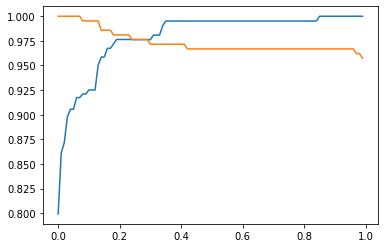

In [15]:
# Plotting Precsion and Recall 
plt.plot(df_scores.threshold, df_scores.P, label='precision')
plt.plot(df_scores.threshold, df_scores.R, label='recall')

#### Answer Question 3: 0.3

In [16]:
df_scores['F1'] = 2 * ((df_scores.P * df_scores.R) / (df_scores.P + df_scores.R))
df_scores[df_scores['F1'] == df_scores['F1'].max()]

,threshold,tp,fp,fn,tn,P,R,F1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


#### Answer Question 4: 0.4

In [17]:
def train(df, y, C):
    dv = DictVectorizer(sparse=False)
    
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)
    
    return dv, model

In [18]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [19]:
n_splits = 5
scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card
    y_val = df_val.card
    
    dv, model = train(df_train, y_train, 1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
    print("%.3f" %(np.std(scores)))

0.000
0.000
0.000
0.002
0.003


#### Answer Question 5: 0.003

In [20]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card
        y_val = df_val.card

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C=%s, %.3f +- %.3f" %(C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C=0.1, 0.995 +- 0.004
C=1, 0.996 +- 0.003
C=10, 0.996 +- 0.003


#### Answer Question 6: 1